In [1]:
try:
    from ase import Atoms
    from ase.calculators.lj import LennardJones
    print("successfully imported ase")
except ImportError:
    !! pip install ase --user --upgrade
    print("completed installing ASE")

successfully imported ase


In [2]:
try:
    import torch
    print("successfully imported torch")
except ImportError:
    !! pip install torch --user --upgrade
    print("completed installing torch")

successfully imported torch


In [3]:
try:
    import dscribe
    print("successfully imported dscribe")
except ImportError:
    !! pip install dscribe --user --upgrade
    print("completed installing dscribe")

successfully imported dscribe


In [4]:
try:
    import numpy as np
    print("successfully imported numpy")
except ImportError:
    !! pip install numpy --user --upgrade
    print("completed installing numpy")

successfully imported numpy


In [5]:
try:
    from matplotlib import pyplot as plt
    print("successfully imported matplotlib")
except ImportError:
    !! pip install matplotlib --user --upgrade
    print("completed installing matplotlib")

successfully imported matplotlib


In [10]:
import glob
import sys

sys.path.append("../")
from aenet_GPR.util import ReferenceData
from aenet_GPR.src import gpr_batch
from aenet_GPR.inout import io_train_parameters, io_test_parameters
from aenet_GPR.util.prepare_data import standard_output, inverse_standard_output

# 1. Read reference training/test data from xsf files

In [12]:
!! unzip ../aenet_example/1_H2/train_set.zip -d ./1_H2/

['Archive:  ../aenet_example/1_H2/train_set.zip',
 'replace ./1_H2/__MACOSX/._train_set? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [13]:
!! unzip ../aenet_example/1_H2/test_set.zip -d ./1_H2/

['Archive:  ../aenet_example/1_H2/test_set.zip',
 'replace ./1_H2/__MACOSX/._test_set? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [15]:
train_xsf_files = glob.glob("./1_H2/train_set/file_*")
train_xsf_files.sort()
train_data = ReferenceData(structure_files=train_xsf_files, file_format='xsf')
train_data.set_data()

print(train_data.energy.shape)
print(train_data.force.shape)

(7,)
(7, 2, 3)


In [16]:
test_xsf_files = glob.glob("./1_H2/test_set/file_*")
test_xsf_files.sort()
test_data = ReferenceData(structure_files=test_xsf_files, file_format='xsf')
test_data.set_data()

print(test_data.energy.shape)
print(test_data.force.shape)

(200,)
(200, 2, 3)


# 2. Model train

In [17]:
if train_data.standardization:
    train_data.standardize_energy_force(train_data.energy)
train_data.config_calculator()

io_train_parameters(data_param=train_data.write_params())


Training parameters
{'num_data': 7, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['H', 'H'], 'num_atom': 2}



# 3. Model evaluation for test set

In [18]:
test_data.calculator = train_data.calculator
io_test_parameters(data_param=test_data.write_params())


Test parameters
{'num_data': 200, 'calculator': {'kerneltype': 'sqexp', 'scale': tensor(0.4000, dtype=torch.float64), 'weight': tensor(1., dtype=torch.float64), 'noise': tensor(1.0000e-06, dtype=torch.float64), 'noisefactor': tensor(0.5000, dtype=torch.float64)}, 'fix_ind': None, 'pbc': False, 'species': ['H', 'H'], 'num_atom': 2}



In [19]:
energy_test_gpr, force_test_gpr, uncertainty_test_gpr = test_data.evaluation(get_variance=True)

if train_data.standardization:
    energy_test_gpr, force_test_gpr = inverse_standard_output(energy_ref=train_data.energy,
                                                              scaled_energy_target=energy_test_gpr,
                                                              scaled_force_target=force_test_gpr)

abs_force_test_gpr = np.linalg.norm(force_test_gpr, axis=2)
abs_force_test = np.linalg.norm(test_data.force, axis=2)

print("Energy MAE:", np.absolute(np.subtract(energy_test_gpr, test_data.energy)).mean())
print("Force MAE:", np.absolute(np.subtract(abs_force_test_gpr, abs_force_test)).mean())
print()
print("Energy MSE:", np.square(np.subtract(energy_test_gpr, test_data.energy)).mean())
print("Force MSE:", np.square(np.subtract(abs_force_test_gpr, abs_force_test)).mean())

Energy MAE: 0.002802978675064543
Force MAE: 0.10320614901090341

Energy MSE: 4.416290622794316e-05
Force MSE: 0.17530410276122968


In [24]:
d_train = []
for image in train_data.images:
    d_train.append(np.linalg.norm(image.get_positions()[1] - image.get_positions()[0]))

d_test = []
for image in test_data.images:
    d_test.append(np.linalg.norm(image.get_positions()[1] - image.get_positions()[0]))

<>:65: SyntaxWarning: invalid escape sequence '\A'
<>:65: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_827/2560971381.py:65: SyntaxWarning: invalid escape sequence '\A'
  ax3.set_xlabel('H-H distance ($\AA$)', fontdict=font_x)


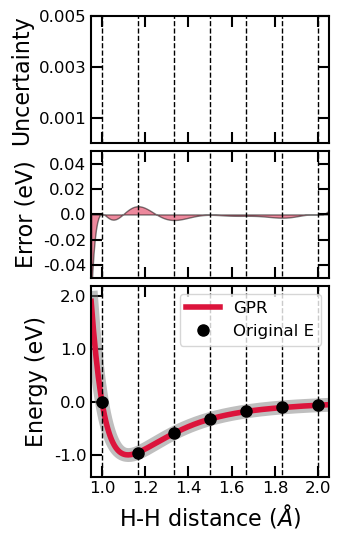

In [27]:
fig = plt.figure(figsize=(3.5, 5.5))
ax1, ax2, ax3 = fig.subplots(3, 1, height_ratios=[1, 1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'} 


# The 1st plot
ax1.fill_between(d_test, uncertainty_test_gpr, 0, label='Uncertainty', color='crimson', alpha=0.5, edgecolor='black')
ax1.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

# ax1.set_xlabel("Error in energy [eV]", fontdict=font_x)
ax1.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax1.get_xticks()]
ax1.set_xticks(x_labels)
ax1.set_xlim([0.95, 2.05])
ax1.set_xticklabels(x_labels, fontdict=font_tick)

ax1.set_ylabel('Uncertainty', fontdict=font_y)
ax1.set_ylim(0, 0.005)
y_labels = [round(label, 3) for label in ax1.get_yticks()]
y_labels = [0.001, 0.003, 0.005]
ax1.set_yticks(y_labels)
ax1.set_ylim([0, 0.005])
ax1.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax1.spines.values()]
ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax1.tick_params(direction='in', length=8, width=1.5)


# The second plot
ax2.fill_between(d_test, np.subtract(energy_test_gpr, test_data.energy), 0, color='crimson', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error (eV)", fontdict=font_y)
ax2.set_ylim([-0.05, 0.05])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-0.04, -0.02, 0.0, 0.02, 0.04]
ax2.set_yticks(y_labels)
ax2.set_ylim([-0.05, 0.05])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.energy, '-', color='gray', alpha=0.5, linewidth=10)
ax3.plot(d_test, energy_test_gpr, '-', label='GPR', color='crimson', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.energy, 'o', label='Original E', color='black', markersize=8)

ax3.set_xlabel('H-H distance ($\AA$)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Energy (eV)', fontdict=font_y)
ax3.set_ylim(-1.4, 2.2)
y_labels = [round(label, 2) for label in ax3.get_yticks()]
# y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-1.4, 2.2)

ax3.legend(loc='upper right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
plt.show()

<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:40: SyntaxWarning: invalid escape sequence '\A'
<>:47: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:40: SyntaxWarning: invalid escape sequence '\A'
<>:47: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_827/2319578034.py:19: SyntaxWarning: invalid escape sequence '\A'
  ax2.set_ylabel("Error $(eV/\AA)$", fontdict=font_y)
/tmp/ipykernel_827/2319578034.py:40: SyntaxWarning: invalid escape sequence '\A'
  ax3.set_xlabel('H-H distance ($\AA$)', fontdict=font_x)
/tmp/ipykernel_827/2319578034.py:47: SyntaxWarning: invalid escape sequence '\A'
  ax3.set_ylabel('Force $(eV/\AA)$', fontdict=font_y)


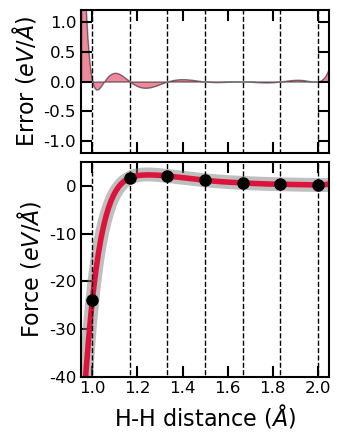

In [28]:
fig = plt.figure(figsize=(3.5, 4.5))
ax2, ax3 = fig.subplots(2, 1, height_ratios=[1, 1.5], sharex=False, sharey=False)

font_x = {'size': 16, 'color': 'black'}
font_y = {'size': 16, 'color': 'black'}
font_tick = {'size': 12, 'color': 'black'}


# The second plot
ax2.fill_between(d_test, np.subtract(force_test_gpr[:, 0, 0], test_data.force[:, 0, 0]), 0, color='crimson', alpha=0.5, edgecolor='black')
ax2.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax2.set_xlim([0.95, 2.05])
x_labels = [round(label, 2) for label in ax2.get_xticks()]
ax2.set_xticks(x_labels)
ax2.set_xlim([0.95, 2.05])
ax2.set_xticklabels(x_labels, fontdict=font_tick)

ax2.set_ylabel("Error $(eV/\AA)$", fontdict=font_y)
ax2.set_ylim([-1.2, 1.2])
y_labels = [round(label, 2) for label in ax2.get_yticks()]
y_labels = [-1.0, -0.5, 0.0, 0.5, 1.0]
ax2.set_yticks(y_labels)
ax2.set_ylim([-1.2, 1.2])
ax2.set_yticklabels(y_labels, fontdict=font_tick)

[x.set_linewidth(1.5) for x in ax2.spines.values()]
ax2.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax2.tick_params(direction='in', length=8, width=1.5)


# The third plot
ax3.plot(d_test, test_data.force[:, 0, 0], '-', color='gray', alpha=0.5, linewidth=10)
ax3.plot(d_test, force_test_gpr[:, 0, 0], '-', label='GPR (PyTorch)', color='crimson', linewidth=4)
ax3.vlines(d_train, ymin=-100, ymax=100, color='black', linestyle='--', linewidth=1)

ax3.plot(d_train, train_data.force[:, 0, 0], 'o', label='Original F', color='black', markersize=8)

ax3.set_xlabel('H-H distance ($\AA$)', fontdict=font_x)
ax3.set_xlim(0.95, 2.05)
x_labels = [round(label, 2) for label in ax3.get_xticks()]
ax3.set_xticks(x_labels)
ax3.set_xticklabels(x_labels, fontdict=font_tick)
ax3.set_xlim(0.95, 2.05)

ax3.set_ylabel('Force $(eV/\AA)$', fontdict=font_y)
ax3.set_ylim(-40, 5)
y_labels = [int(label) for label in ax3.get_yticks()]
# y_labels = [-40, -30, -20, -10, 0]
ax3.set_yticks(y_labels)
ax3.set_yticklabels(y_labels, fontdict=font_tick)
ax3.set_ylim(-40, 5)

# ax3.legend(loc='lower right', fontsize=12, ncol=1, frameon=True)
[x.set_linewidth(1.5) for x in ax3.spines.values()]
ax3.tick_params(bottom=True, top=True, left=True, right=False)
ax3.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax3.tick_params(direction='in', length=8, width=1.5)

fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)

plt.show()